### Problem Description : 
   A retail company “ABC Private Limited” wants to understand the customer purchase behaviour(specifically, purchase amount) 
against various products of different categories. They have shared purchase summary of various customers for selected 
high volume products from last month.

   The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), 
product details (product_id and product category) and Total purchase_amount from last month.

   Now, they want to build a model to predict the purchase amount of customer against various products which will help 
them to create personalized offer for customers against different products.


More data beats clever algorithms, but better data beats more data
-Peter Norvig

#### Goal
    Our Goal is to predict the purchase amount a client is expected to spend on this day.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
train = pd.read_csv("/kaggle/input/black-friday-predictions/train.csv")
test = pd.read_csv("/kaggle/input/black-friday-predictions/test.csv")

In [3]:
print(train.shape)
print(test.shape)


(550068, 12)
(233599, 11)


In [4]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


#### Observations
- Occupation , Product_Category_1 , Product_Category_2, Product_Category_3 values are masked
- No information about stores
- Few information related to products which are product id and the product that falls under different product category
- We have some information related to the Customer such as Age,Gender,Occupation and Maritial_status


#### Assumptions
- We make some assumptions before start,We'll analyse the given features that influence amount spend by customer
- <b>Occupation</b> - People with higher income spend more 
- <b>Marital_Status</b> - People who are single spend more
- <b>City_Category</b> - People from urban city or top tier city spend more because of their higher income level
- <b>Age</b> - People who are below 30 years spend more on gadgets and other electronics stuff

Skewness : 0.6001400037087128
Kurtosis : -0.3383775655851702


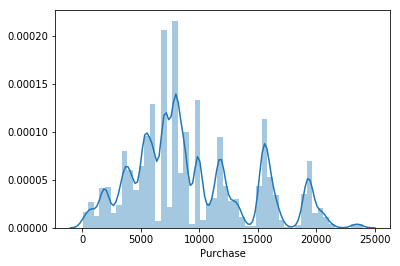

In [5]:
sns.distplot(train['Purchase'])
print("Skewness : {}".format(train['Purchase'].skew()))
print("Kurtosis : {}".format(train.Purchase.kurt()))

In [6]:
# The distribution is moderately skewed

In [7]:
print(train['Purchase'].describe())
print(train[train['Purchase'] == train['Purchase'].min()].shape[0])
print(train[train['Purchase'] == train['Purchase'].max()].shape[0])

count    550068.000000
mean       9263.968713
std        5023.065394
min          12.000000
25%        5823.000000
50%        8047.000000
75%       12054.000000
max       23961.000000
Name: Purchase, dtype: float64
101
3


Observations : 
* Minimum price of the Item is 12 and max to 23961.
* Median value (8047) is lower than mean value (9263) 



### Data Cleaning

In [8]:
train.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

In [9]:
test.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2             72344
Product_Category_3            162562
dtype: int64

In [10]:
# Let's analyse the missing value
# Only this predictors Product_Category_2 & Product_Category_3 has missing values this might be due to that products did not fall under these two categories
train[train['Product_Category_2'].isnull()]['Product_ID'].value_counts()

P00255842    1383
P00278642    1226
P00031042    1200
P00258742     964
P00110542     958
             ... 
P00300742       1
P00365942       1
P00081642       1
P00066342       1
P00077242       1
Name: Product_ID, Length: 1828, dtype: int64

In [11]:
# We analyse firt two top products
print(train[train['Product_ID']=='P00255842']['Product_Category_2'].value_counts(dropna=False))
print(train[train['Product_ID']=='P00278642']['Product_Category_2'].value_counts(dropna=False))

NaN    1383
Name: Product_Category_2, dtype: int64
NaN    1226
Name: Product_Category_2, dtype: int64


In [12]:
train[train['Product_Category_3'].isnull()]['Product_ID'].value_counts()

P00265242    1880
P00058042    1422
P00255842    1383
P00117942    1364
P00110942    1360
             ... 
P00077542       1
P00312542       1
P00135942       1
P00329842       1
P00364342       1
Name: Product_ID, Length: 3103, dtype: int64

In [13]:
# We analyse firt two top products
print(train[train['Product_ID']=='P00265242']['Product_Category_3'].value_counts(dropna=False))
print(train[train['Product_ID']=='P00058042']['Product_Category_3'].value_counts(dropna=False))

NaN    1880
Name: Product_Category_3, dtype: int64
NaN    1422
Name: Product_Category_3, dtype: int64


In [14]:
# Our guess is correct that product doesn't fall under these categories, so it is safe to fill 0
train['Product_Category_2'].fillna(0,inplace=True)
test['Product_Category_2'].fillna(0,inplace=True)
train['Product_Category_3'].fillna(0,inplace=True)
test['Product_Category_3'].fillna(0,inplace=True)

In [15]:
# we remove '+' character
train['Stay_In_Current_City_Years'] = train['Stay_In_Current_City_Years'].replace("4+","4")
test['Stay_In_Current_City_Years'] = test['Stay_In_Current_City_Years'].replace("4+","4")

train['Age'] = train['Age'].replace('55+','56-100')
test['Age'] = test['Age'].replace('55+','56-100')

#### Feature Transformation

In [16]:
# Product ID has so many unique values that won't help us but there is a pattern on product formation. We will split first 4 
# characters this might be some sellers name or for some identification they kept on it

In [17]:
train['Product_Name'] = train['Product_ID'].str.slice(0,4)
test['Product_Name'] = test['Product_ID'].str.slice(0,4)

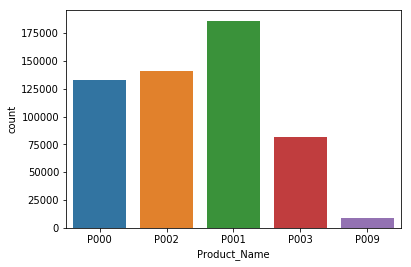

In [18]:
sns.countplot(train['Product_Name'])

In [19]:
train.groupby('Product_Name')['Purchase'].describe().sort_values('count',ascending=False)

,count,mean,std,min,25%,50%,75%,max
Product_Name,,,,,,,,
P001,186026.0,9813.428924,5185.066921,185.0,6041.0,8574.0,13291.0,23960.0
P002,141110.0,8872.737191,4655.924255,187.0,5434.0,7907.0,11703.0,23952.0
P000,132414.0,9539.443654,5152.326628,185.0,5906.0,8117.5,12306.0,23961.0
P003,81216.0,8321.324702,4833.137409,12.0,5263.0,7611.0,11521.0,23940.0
P009,9302.0,8519.379596,5093.650910,343.0,3668.5,8092.0,11971.0,21050.0


#### Feature Creation

##### We'll check purchase of the items based on the available category. My assumption is that if an item available in all the category, there are very high chances that the item is more visible to the user. Let's analys this fact

In [20]:
# Items which are only fall under Product_Category_1 list
pd_cat_1_purchase = train[(train['Product_Category_2'] == 0) & (train['Product_Category_3']==0)]['Purchase']
print("Total no. of Sold Items in Product_Category_1 {}".format(pd_cat_1_purchase.shape[0]))
print("Mean value {}".format(pd_cat_1_purchase.mean()))
print("Median value {}".format(pd_cat_1_purchase.median()))



Total no. of Sold Items in Product_Category_1 173638
Mean value 7518.695389258111
Median value 7075.0


In [21]:
# Items which are available in any two category
pd_cat_2_purchase = train[np.logical_xor(train['Product_Category_2'],train['Product_Category_3'])]['Purchase']
print("Total no. of Sold Items in Product_Category_1 & any one of the other two category {}".format(pd_cat_2_purchase.shape[0]))
print("Mean value is {}".format(pd_cat_2_purchase.mean()))
print("Median value is {}".format(pd_cat_2_purchase.median()))

Total no. of Sold Items in Product_Category_1 & any one of the other two category 209609
Mean value is 8804.312376854048
Median value is 7878.0


In [22]:
# Items which are available in all category
pd_cat_all_purchase = train[(train['Product_Category_2'] != 0) & (train['Product_Category_3']!=0)]['Purchase']
print("Total no. of Sold Items in all Category {}".format(pd_cat_all_purchase.shape[0]))
print("Mean value is {}".format(pd_cat_all_purchase.mean()))
print("Median value is {}".format(pd_cat_all_purchase.median()))

Total no. of Sold Items in all Category 166821
Mean value is 11658.114979528957
Median value is 11756.0


you can see that in all category split where the median is greater than mean. That means most of the richer people purchased the product which comes falls all category. So We'll create a new feature for category split and assign a weight to that. 

In [23]:
train['Category_Weight'] = 0
train.loc[pd_cat_1_purchase.index,'Category_Weight'] = 1
train.loc[pd_cat_2_purchase.index,'Category_Weight'] = 2
train.loc[pd_cat_all_purchase.index,'Category_Weight'] = 3


In [24]:
# Each user has purchased atleast 6 items.
# Based on the count  we'll create a new variable called Frequent_Buyers which holds 1 for Users who purchased more than 100 items
# and 0 for less than 100 items

In [25]:
train['Frequent_Buyers'] = train.groupby('User_ID')['User_ID'].transform(lambda x : 1 if x.count() > 100 else 0)
test['Frequent_Buyers'] = test.groupby('User_ID')['User_ID'].transform(lambda x : 1 if x.count() > 100 else 0)

In [26]:
train.drop(['Product_ID','User_ID'],inplace=True,axis=1)
test.drop(['Product_ID','User_ID'],inplace=True,axis=1)

In [27]:
train['Age'].value_counts()

26-35     219587
36-45     110013
18-25      99660
46-50      45701
51-55      38501
56-100     21504
0-17       15102
Name: Age, dtype: int64

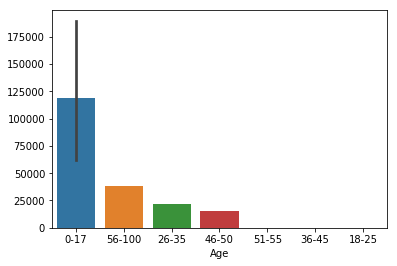

In [28]:
sns.barplot(train['Age'],train['Age'].value_counts().values)

* teenagers or student shows more interest than other ages
* 72% of "0-17" doing the same occupation(probably they are student)

In [29]:
# We'll create a new feature for Student
train['IsStudent'] = 1 * (train['Age']=='0-17')
test['IsStudent'] = 1 * (test['Age']=='0-17')

In [30]:
# Based on our income we spend more, so we'll order occupation by mean value of the purchase and we use the same order for test data also.
order_occupation_by_purchase = train.groupby('Occupation')['Purchase'].describe().sort_values('mean',ascending=False)['mean'].index

In [31]:
train['Occupation']

0         10
1         10
2         10
3         10
4         16
          ..
550063    13
550064     1
550065    15
550066     1
550067     0
Name: Occupation, Length: 550068, dtype: int64

In [32]:
map_occupation = {k: v for v, k in enumerate(order_occupation_by_purchase)}
map_occupation

{17: 0,
 12: 1,
 15: 2,
 8: 3,
 14: 4,
 7: 5,
 16: 6,
 5: 7,
 13: 8,
 6: 9,
 4: 10,
 11: 11,
 3: 12,
 18: 13,
 0: 14,
 10: 15,
 1: 16,
 2: 17,
 20: 18,
 19: 19,
 9: 20}

In [33]:
train['Occupation'] = train['Occupation'].apply(lambda x: map_occupation[x])
test['Occupation'] = test['Occupation'].apply(lambda x: map_occupation[x])

#### Extraordinary Data Analysis

In [34]:
corrIndex = train.corr().nlargest(10,'Purchase')['Purchase'].index
corr = train[corrIndex].corr()

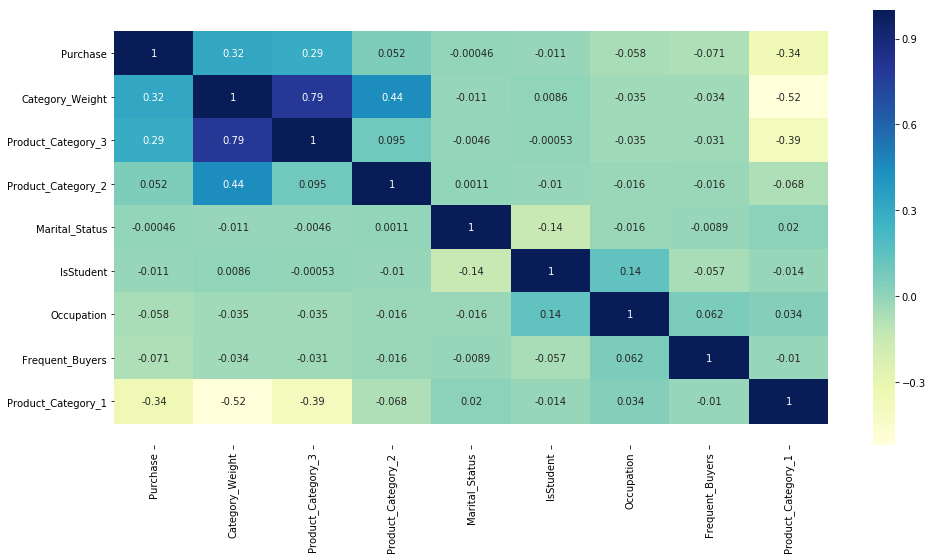

In [35]:
plt.figure(figsize=(16,8))
ax = sns.heatmap(corr,annot=True,cmap="YlGnBu")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [36]:
# There is no satisifactory correlation feature so we will avoid using Linear model.

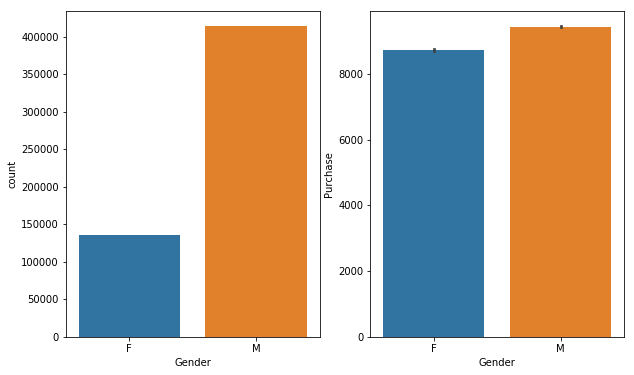

In [37]:
f,ax = plt.subplots(1,2,figsize=(10,6))
sns.countplot(train['Gender'],ax=ax[0])
sns.barplot('Gender','Purchase',data=train,ax=ax[1])

Men was the most shown interest on black friday sales. On plot 2, Eventhough women are less in count but they spent almost equal money spent by men

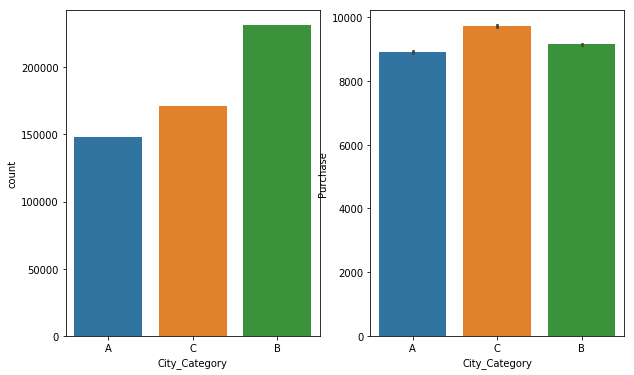

In [38]:
f,ax = plt.subplots(1,2,figsize=(10,6))
sns.countplot(train['City_Category'],ax=ax[0])
sns.barplot('City_Category','Purchase',data=train,ax=ax[1])


In [39]:
# Customer from city B has purchased more items.
# Customer from city C has spent higher Amount Eventhough B has purchased more items.